# LSTM Changepoint detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings

# Ignore only DeprecationWarnings
warnings.filterwarnings('ignore')

In [3]:
import utils
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

In [10]:
session = utils.create_session()

df = session.table("company_revenue_time_series_2") #with cutoff
df = df.to_pandas()


df = df.rename(columns={'DATE': 'ds', 'REVENUE': 'y'})
df = df[['ds', 'y']] # drop everything but these two if there are any

df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values(by='ds')
df = df.reset_index(drop=True)

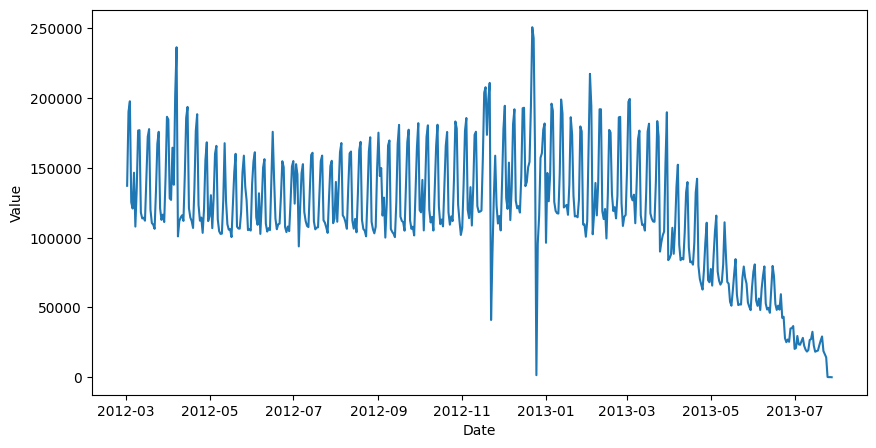

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Values')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()

In [16]:
data = df['y'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

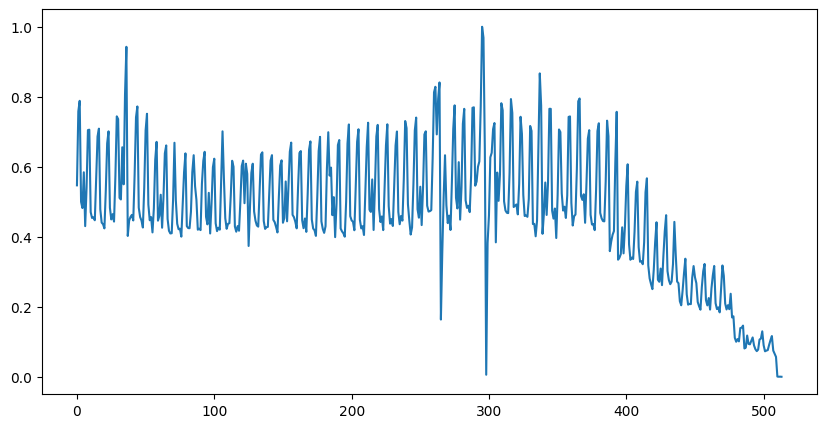

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(scaled_data)
plt.show()

In [20]:
def prepare_data(scaled_data, time_step):
    # Create sequences
    X_train, y_train = [], []
    for i in range(time_step, len(scaled_data)):
        X_train.append(scaled_data[i - time_step:i, 0])
        y_train.append(scaled_data[i, 0])

    # Convert to numpy arrays and then to torch tensors
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()

    X_train = X_train.view(-1, time_step, 1)


    # Prepare test dataset
    test_data = scaled_data[len(scaled_data) - len(X_train) - time_step:]
    
    X_test = []
    for i in range(time_step, len(test_data)):
        X_test.append(test_data[i - time_step:i, 0])

    X_test = torch.tensor(np.array(X_test)).float().view(-1, time_step, 1)

    y_test = scaler.inverse_transform(scaled_data)

    return X_train, y_train, X_test, y_test

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=30, num_layers=2, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #short
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #long
        out, _ = self.lstm(x, (h0, c0))
        out = self.linear(out[:, -1, :])  # Take the last time step's output
        return out


In [48]:
def train_model(X_train, y_train, epochs=10, lr=0.001):

    model = LSTM()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    errors = []

    for epoch in range(epochs):
        model.train()
        outputs = model(X_train)
        optimizer.zero_grad()

        loss = criterion(outputs, y_train.view(-1, 1))
        errors.append(loss.item())
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    return model, errors

In [42]:
def make_predictions(model, X_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        predictions = scaler.inverse_transform(predictions.numpy())
    return predictions

In [43]:
def plot_predictions(predictions, y_test, time_step):
    adjusted_y_test = y_test[time_step:time_step + len(predictions)]
    plt.plot(range(time_step, len(y_test)), adjusted_y_test, label="ndarray Values")
    plt.plot(range(time_step, time_step + len(predictions)), predictions, label="ndarray Values")
    plt.show()

Epoch [1/1000], Loss: 0.3425
Epoch [11/1000], Loss: 0.2271
Epoch [21/1000], Loss: 0.1097
Epoch [31/1000], Loss: 0.0400
Epoch [41/1000], Loss: 0.0297
Epoch [51/1000], Loss: 0.0309
Epoch [61/1000], Loss: 0.0291
Epoch [71/1000], Loss: 0.0279
Epoch [81/1000], Loss: 0.0272
Epoch [91/1000], Loss: 0.0263
Epoch [101/1000], Loss: 0.0250
Epoch [111/1000], Loss: 0.0232
Epoch [121/1000], Loss: 0.0204
Epoch [131/1000], Loss: 0.0166
Epoch [141/1000], Loss: 0.0156
Epoch [151/1000], Loss: 0.0147
Epoch [161/1000], Loss: 0.0143
Epoch [171/1000], Loss: 0.0139
Epoch [181/1000], Loss: 0.0136
Epoch [191/1000], Loss: 0.0135
Epoch [201/1000], Loss: 0.0135
Epoch [211/1000], Loss: 0.0134
Epoch [221/1000], Loss: 0.0134
Epoch [231/1000], Loss: 0.0134
Epoch [241/1000], Loss: 0.0134
Epoch [251/1000], Loss: 0.0134
Epoch [261/1000], Loss: 0.0134
Epoch [271/1000], Loss: 0.0133
Epoch [281/1000], Loss: 0.0133
Epoch [291/1000], Loss: 0.0133
Epoch [301/1000], Loss: 0.0133
Epoch [311/1000], Loss: 0.0133
Epoch [321/1000], L

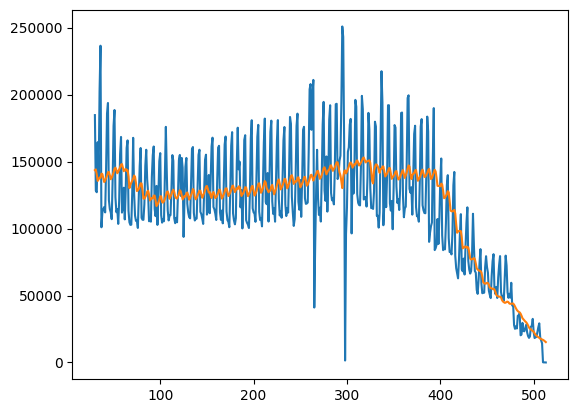

MAPE score = 19.96
MAPE score last 90 = 23.67


In [70]:
time_step = 30

X_train, y_train, X_test, y_test = prepare_data(scaled_data, time_step)

lr = 0.001
epochs = 1000

model, errors = train_model(X_train, y_train, epochs, lr)

predictions = make_predictions(model, X_test)

plot_predictions(predictions, y_test, time_step)

mape_score_all = utils.mape(predictions, y_test[time_step:])
mape_score_comp = utils.mape(predictions[len(predictions)-90:], y_test[len(y_test)-90:])

print(f"MAPE score = {mape_score_all}")
print(f"MAPE score last 90 = {mape_score_comp}")


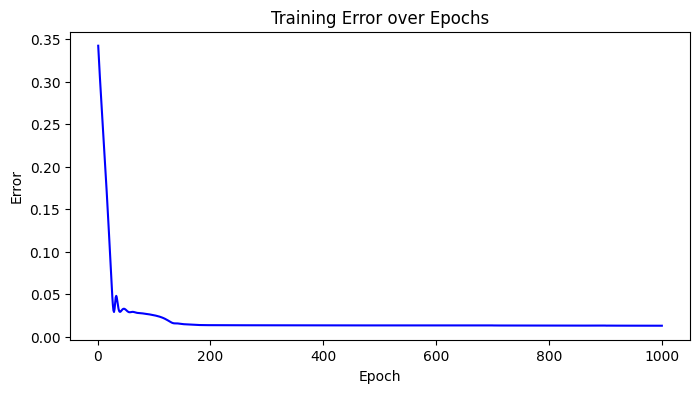

In [71]:

plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs+1), errors, label="Training Error", color="b")

plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Training Error over Epochs")

plt.show()

In [72]:

### STORE RESULTS ###
import os
from datetime import datetime

comment = """
changepoint,  weight_decay=1e-4
"""

file_path = 'lstm_results.csv'
file_exists = os.path.isfile(file_path)

columns = ["datetime", "time_step", "hidden_size", "learning_rate", "epochs", "mape", "mape_last_90", "comment"]

new_row = {
    "datetime": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    "time_step": time_step,
    "hidden_size": model.hidden_size,
    "learning_rate": lr,
    "epochs": epochs,
    "mape": mape_score_all,
    "mape_last_90": mape_score_comp,
    "comment": comment
}

if not file_exists:
    df = pd.DataFrame([new_row], columns=columns)
    df.to_csv(file_path, index=False)
else:
    df = pd.DataFrame([new_row], columns=columns)
    df.to_csv(file_path, mode='a', header=False, index=False)

print(f'Results saved to {file_path}')

Results saved to lstm_results.csv


In [73]:
results = pd.read_csv(file_path)
results

,datetime,time_step,hidden_size,learning_rate,epochs,mape,mape_last_90,comment
0,2024-11-04 15:36:04,20,20,0.0010,100,20.34,18.31,NaN
1,2024-11-04 15:38:10,20,20,0.0010,200,20.35,18.26,NaN
2,2024-11-04 15:41:25,20,20,0.0010,300,20.35,18.21,NaN
3,2024-11-04 15:41:46,20,20,0.0010,400,18.47,9.37,NaN
4,2024-11-05 09:09:14,20,20,0.0010,400,18.38,11.96,NaN
5,2024-11-05 09:29:27,20,20,0.0001,400,20.35,18.18,NaN
6,2024-11-05 09:32:08,20,20,0.0010,1000,18.29,7.39,NaN
7,2024-11-05 09:33:11,20,10,0.0010,1000,18.23,9.57,NaN
8,2024-11-05 09:34:35,20,20,0.0010,1000,18.11,9.39,\nweight_decay=1e-5\n
9,2024-11-05 09:36:03,20,20,0.0010,500,18.42,9.23,\nweight_decay=1e-5\n


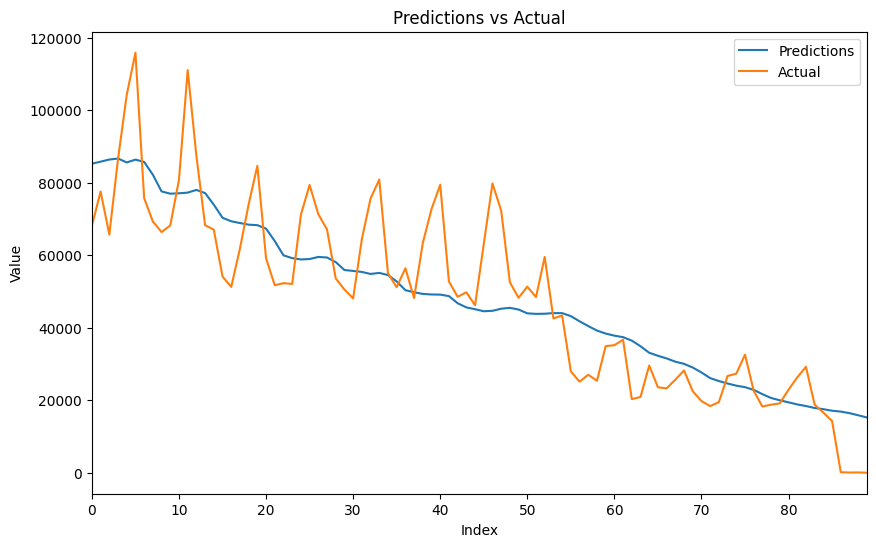

In [74]:
plt.figure(figsize=(10, 6))

# Define the range for the last 90 points
x_range = range(len(predictions[len(predictions) - 90:]))

plt.plot(x_range, predictions[len(predictions) - 90:], label='Predictions')
plt.plot(x_range, y_test[len(y_test) - 90:], label='Actual')

# Set x-axis limits to match the length of the plotted data
plt.xlim(0, 89)  # 0 to 89 for the last 90 points

plt.legend()  # Optional: Add a legend to distinguish the lines
plt.xlabel('Index')  # Optional: Label for the x-axis
plt.ylabel('Value')  # Optional: Label for the y-axis
plt.title('Predictions vs Actual')  # Optional: Title for the plot
plt.show()

In [76]:
rmse = np.sqrt(np.mean((y_test[len(y_test) - 90:].flatten() - predictions[len(predictions) - 90:].flatten()) ** 2))
rmse

12768.96532770697